In [1]:
import sys
import os

# Get the absolute path to the project directory
project_dir = os.path.abspath("..")

# Append the project directory to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [2]:
import yfinance as yf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
from dataclasses import asdict, is_dataclass, dataclass
import os
import json
import pickle
from pandas.api.types import is_datetime64_any_dtype
import scipy
import numpy as np
import polars as pl
from scipy.stats import linregress
from typing import Dict, List

from src.common.AssetData import AssetData
from src.common.AssetDataPolars import AssetDataPolars
from src.common.AssetDataService import AssetDataService
from src.common.AssetFileInOut import AssetFileInOut 
from src.databaseService.OutsourceLoader import OutsourceLoader

from src.common.AssetFileInOut import AssetFileInOut
from src.mathTools.CurveAnalysis import CurveAnalysis
from src.mathTools.SeriesExpansion import SeriesExpansion

In [3]:
assets=AssetFileInOut("../src/stockGroups/bin").loadDictFromFile("group_snp500_over20years")

# Convert to Polars for speedup
assetspl: Dict[str, AssetDataPolars] = {}
for ticker, asset in assets.items():
    assetspl[ticker]= AssetDataService.to_polars(asset)

In [ ]:
# Parameters
M = 1  # Number of functions (can be increased to test vectorization)
N = 65  
# Known Fourier coefficients
a0 = 1.0+1j
a1 = 0.5-1j
a2 = 0.25+0.3j
b1 = -0.3+1j
b2 = 0.15-0.5j
# Generate sample points
t = np.linspace(-np.pi, np.pi, N+1)[:-1]  # Exclude the last point to get N points
# Create the test function f(t) with known Fourier coefficients
f_t = (a0 +
       a1 * np.cos(t) +
       a2 * np.cos(2 * t) +
       b1 * np.sin(t) +
       b2 * np.sin(2 * t))
# Reshape f_t to match the expected input shape (M x N)
f_t = f_t.reshape(M, N)

rFfft = np.fft.fft(np.real(f_t), axis=1)
iFfft = np.fft.fft(np.imag(f_t), axis=1)

cjrFfft = np.conj(rFfft)
cjiFfft = np.conj(iFfft)
signmat = (-1) ** np.arange(N)
signmat = np.tile(signmat, (M, 1))
ar = (rFfft + cjrFfft) * signmat / (N * 2)
br = (rFfft - cjrFfft) * signmat * (1j) / (N * 2)
ai = (iFfft + cjiFfft) * signmat / (N * 2)
bi = (iFfft - cjiFfft) * signmat * (1j) / (N * 2)
CosConst = (np.hstack([ar[:, :1], ar[:, 1:N//2] + (-1) ** (N%2)*np.fliplr(ar[:, N//2+N%2+1:])]) +
              1j * np.hstack([ai[:, :1], ai[:, 1:N//2] + (-1) ** (N%2)*np.fliplr(ai[:, N//2+N%2+1:])]))
    
SinConst = (np.hstack([br[:, :1], br[:, 1:N//2] - (-1) ** (N%2)*np.fliplr(br[:, N//2+N%2+1:])]) +
              1j * np.hstack([bi[:, :1], bi[:, 1:N//2] - (-1) ** (N%2)*np.fliplr(bi[:, N//2+N%2+1:])]))

In [5]:
aIRM = assetspl["NVDA"]
pricesArray = aIRM.shareprice["Close"]
aidx = pricesArray.len() - 10
m=6
pastPrices = pricesArray.slice(aidx-m * 21-1, m * 21 +1).to_numpy()
futurePrices = pricesArray.slice((aidx+1),5).to_numpy()

In [7]:
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
n = len(pastPrices)
x = np.arange(n)
fx0: float = pastPrices[0]
fxend: float = pastPrices[n-1]
yfit = fx0 + (fxend-fx0)*(x/(n-1))
skewedPrices = pastPrices-yfit
print(skewedPrices.shape)
print(np.flipud(-skewedPrices[0:n-1]).shape)
fourierInput = np.concatenate((skewedPrices,np.flipud(-skewedPrices[:n-1])))
cs = CubicSpline(np.arange(len(fourierInput)), fourierInput, bc_type='periodic')
multFactor = 128
fourierInputSpline = cs(np.linspace(0, len(fourierInput)-1, 1 + (len(fourierInput) - 1) * multFactor))
fourierInputSmooth = gaussian_filter1d(fourierInputSpline, sigma=32, mode="wrap")
res_cos, res_sin = SeriesExpansion.getFourierConst(fourierInputSmooth)
res_cos=res_cos.T.real
res_sin=res_sin.T.real
#features = [fxend, (fxend-fx0)/(n-1), ]

(127,)
(126,)


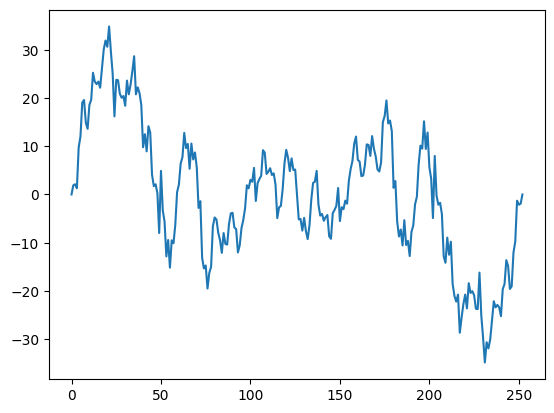

In [ ]:
plt.plot(fourierInput)

In [8]:
N = len(fourierInputSmooth)
K = len(res_cos)
# Create an array of time points corresponding to the original function's domain
t = np.linspace(-np.pi, np.pi, N, endpoint=False)
# Initialize the reconstructed function
f_reconstructed = np.zeros(N)
# Reconstruct the function using the Fourier series
truncated = 20
for n in range(0,truncated):
    f_reconstructed += res_cos[n] * np.cos(n * t) + res_sin[n] * np.sin(n * t)
# Calculate the mean squared error between the original and reconstructed functions
error = np.mean((fourierInputSmooth - f_reconstructed) ** 2)
error

np.float64(11.707964257710543)

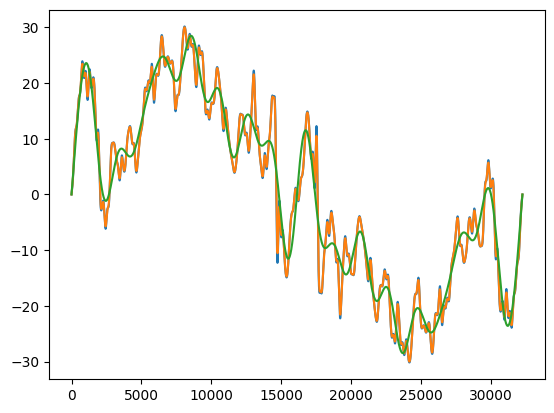

In [9]:
plt.plot(fourierInputSpline)
plt.plot(fourierInputSmooth)
plt.plot(f_reconstructed)

testing series Expansion

In [25]:
relDiffPerStep, res_cos, res_sin = SeriesExpansion.getFourierInterpCoeff(pastPrices, multFactor, 10)
cutoff=2
resarr, rsme = SeriesExpansion.getFourierInterpFunct(res_cos[:cutoff], res_sin[:cutoff], pastPrices)

2.5201755236534904


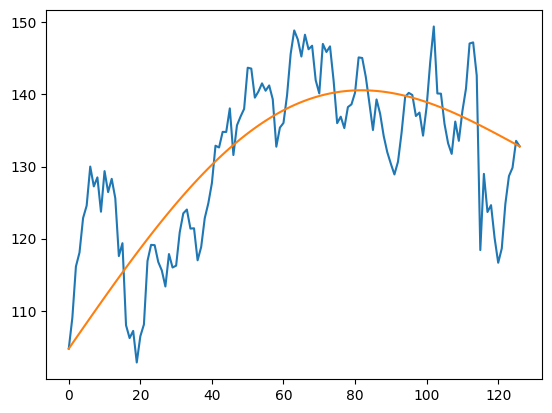

In [26]:
plt.plot(pastPrices)
plt.plot(resarr)
print(rsme)

In [27]:
res_cos = np.array(res_cos[:cutoff])
res_sin = np.array(res_sin[:cutoff])
res_abs = np.sqrt(res_cos[:cutoff]**2+ res_sin[:cutoff]**2)
res_sign = (np.sign(res_cos[:cutoff])+1.0)/2.0

print(res_cos)
print(res_sin)
print(res_abs)
print(res_sign)

[-5.85106843e-17 -1.92382900e-03]
[ 4.40551034e-17 -1.97533413e+01]
[7.32417389e-17 1.97533414e+01]
[0. 0.]


Trying to get good approx without setting ends to zero 

In [14]:
fourierInput = pastPrices
cs = CubicSpline(np.arange(len(fourierInput)), fourierInput)
fourierInputSpline = cs(np.linspace(0, len(fourierInput)-1, 1 + (len(fourierInput) - 1) * multFactor))
fourierInputSmooth = gaussian_filter1d(fourierInputSpline, sigma=np.max([multFactor//4,1]))
res_cos, res_sin = SeriesExpansion.getFourierConst(fourierInputSmooth)
res_cos=res_cos.T.real.flatten().tolist()
res_sin=res_sin.T.real.flatten().tolist()

N = len(fourierInputSmooth)
K = len(res_cos)
t = np.linspace(-np.pi, np.pi, N, endpoint=False)
f_reconstructed = np.zeros(N)
truncated = 20
for n in range(0,truncated):
    f_reconstructed += res_cos[n] * np.cos(n * t) + res_sin[n] * np.sin(n * t)
error = np.mean((fourierInputSmooth - f_reconstructed) ** 2)
error

np.float64(6.5150403517942825)

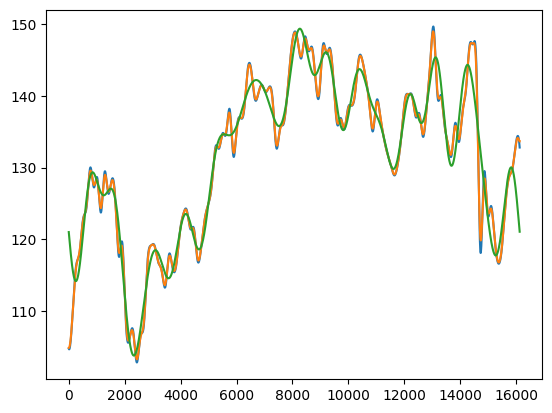

In [15]:
plt.plot(fourierInputSpline)
plt.plot(fourierInputSmooth)
plt.plot(f_reconstructed)